In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from read_wandb import wandb_results
api = wandb_results("NLP_PROJECT", wandb_username="nitzan-manor")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

In [4]:
def result_metric(sweeps, group_name, drop_list=[], drop_HPT=False, metric=BASE_METRIC, epoch="best"):
    df = api.get_sweeps_results(sweeps, metric=metric) 
    # change bool to int
    df = df.replace({True: 1, False: 0})
    df = df.replace({"EFs": 0, "BERT_TOKEN": 1,"GPT2_TOKEN":2,"ROBERTA_TOKEN":3})
    df = df.replace({"CE": 0, "NLL": 1})
    

    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size" and c!="config_FEATURES_PATH"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1] +["config_dropout"]
    print(HPT_cols)
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
    

    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    df_numeric = df[numeric_cols]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed"])
    

    mean_df = grouped.mean()
    std_df = grouped.std()
    
    
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)

    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))

    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df

def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [8]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)
    
sweep_results = result_metric(["nvarilhr", "pnga6a1h"], "Hidden dim", drop_HPT=False, epoch="best")
#sweep_results = result_metric(['enby6lto', 'fqqsn168', 's7mw5paw'], "Hidden dim", drop_HPT=False, epoch="best") # for phase 3

sweep_results

Total number of sweeps: 2
Download sweep_id='nvarilhr' data...
Download sweep_id='pnga6a1h' data...
['config_seed', 'config_use_fc', 'config_features', 'config_input_dim', 'config_REVIEW_DIM', 'config_use_residuals', 'config_use_positional_encoding', 'config_dropout']


mean  \
config_use_fc config_features config_input_dim config_REVIEW_DIM config_use_residuals config_use_positional_encoding config_dropout             
0             0               60               37                0                    0                              0               0.837695   
                                                                                      1                              0               0.837531   
                                                                 1                    0                              0               0.837962   
                                                                                      1                              0               0.836540   
              1               220              196               0                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
                                                                 1                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
              2               344              319               0                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
                                                                 1                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
              3               348              323               0                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
                                                                 1                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
1             0               60               37                0                    0                              0               0.833071   
                                                                                      1                              0               0.831522   
                                                                 1                    0                              0               0.831886   
                                                                                      1                              0               0.833052   
              1               220              196               0                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
                                                                 1                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
              2               344              319               0                    0                              0               0.530216   
                                                                                      1                              0               0.530216   
                                                                 1           

In [5]:
groups = []
lower_bounds = []
upper_bounds = []

pastel_colors = ['#FFB6C1', '#87CEEB', '#98FB98', '#FFD700', '#FFA07A', '#20B2AA', '#BA55D3', '#87CEFA']

for index, row in sweep_results.iterrows():
    if row.name[1] == 0:
        label = f"fc:{row.name[0]} res:{row.name[4]} PE:{row.name[5]}"
        groups.append(label)
        lower_bounds.append(row['CI'][0])
        upper_bounds.append(row['CI'][1])

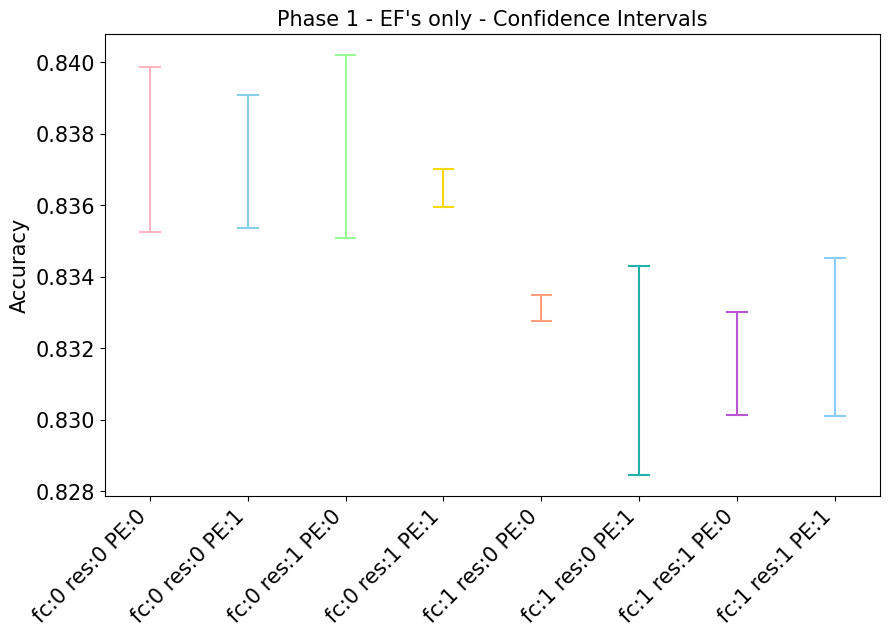

In [6]:
# Plotting
plt.figure(figsize=(10, 6))
for i, group in enumerate(groups):
    group_pos = i + 1  # Numeric position of the group
    plt.plot([group_pos, group_pos], [lower_bounds[i], upper_bounds[i]], color=pastel_colors[i])
    # Add lines at the beginning and end of each confidence interval
    plt.plot([group_pos-0.1, group_pos+0.1], [lower_bounds[i], lower_bounds[i]], color=pastel_colors[i])
    plt.plot([group_pos-0.1, group_pos+0.1], [upper_bounds[i], upper_bounds[i]], color=pastel_colors[i])
plt.ylabel('Accuracy', fontsize=15)
plt.title('Phase 1 - EF\'s only - Confidence Intervals', fontsize=15)
plt.xticks(range(1, len(groups) + 1), groups, rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)
plt.show()